# Final Project 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

%matplotlib inline

In [3]:
full_dataset = pd.read_csv('IMDb movies.csv')
full_dataset.head(3)

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,actors,description,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics
0,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,1906-12-26,"Biography, Crime, Drama",70,Australia,NaN,Charles Tait,...,"Elizabeth Tait, John Tait, Norman Campbell, Be...",True story of notorious Australian outlaw Ned ...,6.1,537,$ 2250,NaN,NaN,NaN,7.0,7.0
1,tt0001892,Den sorte drøm,Den sorte drøm,1911,1911-08-19,Drama,53,"Germany, Denmark",NaN,Urban Gad,...,"Asta Nielsen, Valdemar Psilander, Gunnar Helse...",Two men of high rank are both wooing the beaut...,5.9,171,NaN,NaN,NaN,NaN,4.0,2.0
2,tt0002101,Cleopatra,Cleopatra,1912,1912-11-13,"Drama, History",100,USA,English,Charles L. Gaskill,...,"Helen Gardner, Pearl Sindelar, Miss Fielding, ...",The fabled queen of Egypt's affair with Roman ...,5.2,420,$ 45000,NaN,NaN,NaN,24.0,3.0


## Part 1. Task formalization and Evaluation criteria

1.1 Select your target variable, explain your choice. Separate target variable from the feature matrix.

In [4]:
full_dataset.columns

Index(['imdb_title_id', 'title', 'original_title', 'year', 'date_published',
       'genre', 'duration', 'country', 'language', 'director', 'writer',
       'production_company', 'actors', 'description', 'avg_vote', 'votes',
       'budget', 'usa_gross_income', 'worlwide_gross_income', 'metascore',
       'reviews_from_users', 'reviews_from_critics'],
      dtype='object')

I decided to choose avg_vote as a target variable. 

According to the task we are creating a model for film-producing company in order make sure that films are successful.

Success is subjective because some Indian film from small production company  with avgerage vote equal to 9 and Marvel film with average vote 9 have different level of success. 

In this case I define success as an audience appreciation: if people liked the film - it is successful. That's why target variable is avg_vote

In [5]:
full_dataset.sort_values('avg_vote', ascending=False).head(3)

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,actors,description,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics
52002,tt10914342,Kirket,Kirket,2019,2019-10-18,"Drama, Sport",132,India,Hindi,Yogendra Singh,...,"Kirti Azad, Sonam Chhabra, Sonu Jha, Jai Kumar...","The story of how one man, single-handedly chan...",10.0,587,NaN,NaN,NaN,NaN,11.0,NaN
51300,tt10370434,Runam,Runam,2019,2019-04-12,Romance,131,India,Telugu,Srinivas Gundareddy,...,"Priyanka Augustin, Gopi Krishna, Shilpa Mahendar",NaN,9.7,133,NaN,NaN,NaN,NaN,NaN,NaN
51927,tt10867504,Fan,Fan,2019,2019-08-23,Drama,145,India,Kannada,Balavalli Darshith Bhat,...,"Ravi Bhat, Sangeetha Bhat, Aryan Gowda, Naveen...",Protagonist Drushya (Aryan Gowda) is a popular...,9.6,1010,INR 20000000,NaN,NaN,NaN,21.0,NaN


avg_vote is a discrete ordinal variable with values from 1 to 10 (89 values). As it is a user vote, we know that this value can't be more than 10 or less than 1. Here we can solve a classification problem. In order to do this I'll create a new feature which contains labels for user ratings in order to decrease number of classes. 

In [6]:
#create 5 new classes

conditions = [
    (full_dataset['avg_vote'] < 3.5), 
    (full_dataset['avg_vote'] >= 3.5) & (full_dataset['avg_vote'] < 5.5), 
    (full_dataset['avg_vote'] >= 5.5) & (full_dataset['avg_vote'] < 7.5), 
    (full_dataset['avg_vote'] >= 7.5) & (full_dataset['avg_vote'] < 9.5),
    (full_dataset['avg_vote'] >= 9.5) 
    
]

values = ['Bad', 'Satisfactory', 'Good', 'Very good', 'Excellent']

full_dataset['success'] = np.select(conditions, values)

1.2 Explain which task are you going to solve (is it a regression, classification or something else)? 

Classification task is about predicting a label and regression is about predicting a quantity. 

Classification predicts descrete class variables and a regression algorithm predicts continuous quantity. In this case we are going to solve a classification task using additional variable 'success' which contains categories for user votes. 

In [7]:
X = full_dataset.drop(columns=['avg_vote', 'success'])
y = full_dataset['success']

In order to make our Ml algorithm work we should convert labels into a numeric form. For this we can use `LabelEncoder()`

In [8]:
le = LabelEncoder()
y = le.fit_transform(y)

1.3 Select a metric. Is it already implemented in sklearn? If yes, import it. If not, it is time to write a function which will calculate it. 

In [9]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

## Part 2. Exploratory Data Analysis (EDA) and Feature Engineering


### 2.1 Split data into train and test

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

### 2.2 Explore and preprocess the data

Explore you data: make plots, print tables. Make sure to write your observations.  Do not forget to fill-in missing values, define relevant columns transformations. 



#### Drop useless columns

Number of numerical features = 6 

Distribution of numerical features:


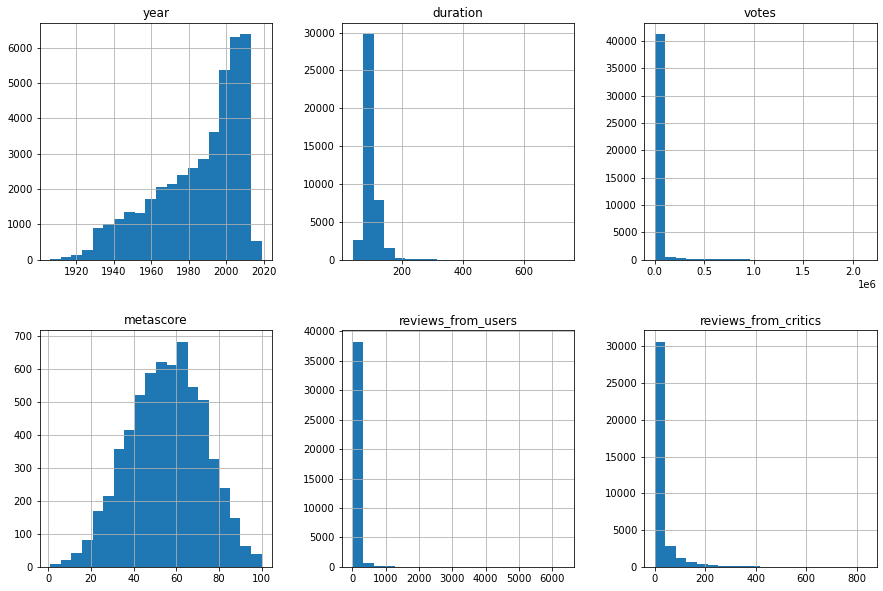

In [11]:
num_cols = X_train.columns[(X_train.dtypes == "int64") |(X_train.dtypes == "float64")].tolist() #
print("Number of numerical features =", len(num_cols), "\n")

print("Distribution of numerical features:")
X_train[num_cols].hist(bins=20, grid=True, figsize=(15, 10), layout=(2, 3))
plt.show()

At first, let's handle the missing values. 

Let's see which columns have a missing values:


In [12]:
X_train.isnull().sum()

imdb_title_id                0
title                        0
original_title               0
year                         0
date_published               0
genre                        0
duration                     0
country                      3
language                   303
director                    14
writer                     573
production_company        1947
actors                      23
description               1388
votes                        0
budget                   30340
usa_gross_income         33778
worlwide_gross_income    28732
metascore                35946
reviews_from_users        2832
reviews_from_critics      5740
dtype: int64

Train dataset contains 42 000 objects and more that 65% of them have no info about budget, usa gross income and worlwide gross income. Thus I suppose to remove budget, usa_gross_income,worldwide gross income because there are too many missing values, different currencies and timeranges, so it is meaningless to compare them. Also I suppose to remove metascore because there are too many missing values. 

Also I would like to remove such features as imdb_title_id, title, original title, actors and description, because it is text informational data, which is not very useful for us and hard to interpretate. 

We have two columns defining date: year and full date. I suppose year is enough, so we can drop the date column. 

Also I suggest to drop director and writer, because we have info about production company, it is enougth to predict the success. There are too many unique writers and directors to pay attention on them. 

In [13]:
X_train = X_train.drop(columns=['budget', 'usa_gross_income', 'worlwide_gross_income', 'actors', 'description',
                                'imdb_title_id', 'title', 'original_title', 'metascore',
                               'date_published', 'writer', 'director'])
X_test = X_test.drop(columns=['budget', 'usa_gross_income', 'worlwide_gross_income', 'actors', 'description',
                                'imdb_title_id', 'title', 'original_title', 'metascore',
                             'date_published', 'writer', 'director'])


In [14]:
X_train

,year,genre,duration,country,language,production_company,votes,reviews_from_users,reviews_from_critics
47403,2006,Drama,91,Spain,Spanish,NaN,334,3.0,3.0
38665,1958,"Drama, Romance",88,Turkey,Turkish,Emin Film,179,2.0,NaN
3701,1941,Drama,125,Germany,German,Tobis Filmkunst,133,11.0,2.0
57103,2009,Drama,100,Czech Republic,Czech,In Film Praha,650,3.0,45.0
31025,1963,"Family, Drama",86,USA,English,Wrather Productions,199,5.0,1.0
...,...,...,...,...,...,...,...,...,...
50132,2006,Drama,96,Japan,Japanese,Love My Life Partners,761,7.0,4.0
53121,2009,"Action, Horror, Sci-Fi",101,"Serbia, Italy, Spain","English, Serbian",Talking Wolf Productions,2985,49.0,40.0
17460,1977,Horror,85,USA,English,NaN,332,9.0,11.0
24744,1990,Comedy,92,France,French,Hugo Films,458,NaN,NaN


#### Defining column transformers

We have a lot categorical features. 

Such features as `country`, `language` and `genre` may have string with more than one element as a value. The first value in each cell in such columns is more important and paramount, so I will extract only first value from strings in this columns using `ListCreator`


Also we have a `production_company` categorical feature, there a lot of unique vales so using OHE will not be effective. Instead we will use frequency encoding: the category is assigned as per the frequency of value in its total lot. (`FreqEncoder`)

Also for categorical features I created a transformer which fills missing values with 'Unknown' value `FillEmptyCat`.


For all numeric features we will apply `StandardScaler`, for categorical features - `SimpleImputer`.

In [15]:
# this class returns first value from list of values of a feature
class ListCreator(BaseEstimator,TransformerMixin):
    def __init__(self,cols=None):
        self.cols = cols

    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        cols_to_transform = list(X.columns)
        if self.cols:
            cols_to_transform = self.cols
        for col in cols_to_transform:
          X[col] = X[col].apply(lambda x: x[:x.index(',')] if x.find(',') != -1 else x)
        
        return X


In [16]:
# class that implements frequency encoding
class FreqEncoder(BaseEstimator,TransformerMixin):
    def __init__(self,cols=None):
        self.cols = cols

    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        cols_to_transform = list(X.columns)
        if self.cols:
            cols_to_transform = self.cols
        for col in cols_to_transform:
            freqs = (X.groupby(col).size())/len(X)
            X[col] = X[col].apply(lambda x: freqs[x])
                   
        return X


In [17]:
#fill empty values with Unknown string
class FillEmptyCat(BaseEstimator,TransformerMixin):
    def __init__(self,cols=None):
        self.cols = cols

    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        cols_to_transform = list(X.columns)
        if self.cols:
            cols_to_transform = self.cols
        for col in cols_to_transform:
            X[col] = X[col].fillna(f'Unknown_{col}')
        
        return X

In [18]:
num_pipe = make_pipeline(
    SimpleImputer(missing_values=np.nan, strategy='mean'),
    StandardScaler()
)

lists_pipe = make_pipeline(
    FillEmptyCat(),
    ListCreator(),
    OneHotEncoder(handle_unknown='ignore')
) 

freq_pipe = make_pipeline(
    FillEmptyCat(),
    FreqEncoder()
)



column_transformer = ColumnTransformer([
    ('strings_to_lists', lists_pipe, ['genre', 'country', 'language']),
    ('frequency_encode', freq_pipe, ['production_company']),
    ('num_scaler', num_pipe, ['year', 'duration', 'votes', 'reviews_from_users', 'reviews_from_critics'])
],
remainder='passthrough'
)

In [19]:
model = Pipeline([
    ('transformer', column_transformer),
    ('classifier', KNeighborsClassifier())
])

### Part 3.

Train and compare the models

3.1. Select models, you are going to train, select hyperparameters that have to be tunes.

Remember that this is a classification problem. In order to solve it I will use decision tree(Random forest, support vector machine and k-nearest neighbors. 

For RandomForestClassifier() I will tune n_estimators, max_depth.

For SVC: C and kernel

For KNN: n_neighbors

3.2 Use cross-validation to compare models and select best set of hyperparameters

In [20]:
from sklearn.linear_model import LogisticRegression
parametrs = [
    {
      'classifier': [RandomForestClassifier(random_state=42)],
      'classifier__n_estimators': [30, 40, 50],
      'classifier__max_depth': [30, 40, 50]
    },
    {
        'classifier': [SVC()],
        'classifier__C': [5, 7, 8],
        'classifier__gamma': ['auto', 'scale']
    },
    {
        'classifier': [LogisticRegression(solver='saga')],
        'classifier__penalty': ['l2', 'l1'],
        'classifier__C': [1, 5, 6]
    }
]

grid_pipe = GridSearchCV(model, param_grid=parametrs, cv=10, scoring='accuracy',
                        n_jobs=-1)
grid_pipe.fit(X_train, y_train)

/Users/riyashuleva/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
/Users/riyashuleva/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/riyashuleva/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/riyashuleva/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/riyashuleva/opt/anaconda3/lib/

/Users/riyashuleva/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/riyashuleva/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/riyashuleva/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/riyashuleva/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/riyashuleva/opt/anaconda3/lib/python3.9/site-packages

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('strings_to_lists',
                                                                         Pipeline(steps=[('fillemptycat',
                                                                                          FillEmptyCat()),
                                                                                         ('listcreator',
                                                                                          ListCreator()),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['genre',
  

3.3 Which model and setup is the best? How does it perform on the test dataset? If you were to present this model to the client, how would you describe it?

In [21]:
print('Best accuracy: ', grid_pipe.best_score_)
print('Best model setup: ', grid_pipe.best_estimator_.steps[1][1])

Best accuracy:  0.7324741226869035
Best model setup:  RandomForestClassifier(max_depth=50, n_estimators=50, random_state=42)


Performing model on a test dataset:

In [22]:
grid_pipe.best_estimator_.fit(X_train, y_train)
y_pred = grid_pipe.best_estimator_.predict(X_test)
accuracy_score(y_test, y_pred)

0.7365448504983388

Best setup model according to Grid Search CV is RandomForestClassifier(max_depth=40, n_estimators=50, random_state=42). It's accuacy on train dataset is equal to 0.73. 

Accuracy is a ratio of correctly predicted observation to the total observation. It means that 73% of observations were predicted correctly. 

Test data has 74% accuracy. It means that 74% of observations were predicted correctly. In my opinion it is a good measure for such inbalanced dataset. 

Also we can check f1 score: 



In [23]:
f1_score(y_test, y_pred, average='weighted')

0.7103588230663956

This model predicts the success of the film according ro public appreciation and taste: genre, language, amout of votes, reviews. Also it takes into account year and production company. This model is more about audience tastes and genres and countries. 